In [410]:
### data processing tools
import os
import pandas as pd
import re
from collections import OrderedDict, defaultdict
import operator

import warnings
warnings.filterwarnings('ignore') # ignore warnings to keep notebook clean

### text processing tools
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
import nltk
from nltk.corpus import stopwords

### visualization tools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

___

# Introduction

In the following, we will investigate the United Nations Security Council dataset.

> This dataset contains meeting protocols from the United Nations Security Council meetings between January 1995 and December 2017. The protocols were downloaded as PDF documents from http://www.un.org/en/sc/meetings/ and converted to text using OCR. In total, the corpus contains 65,393 speeches extracted from 4,958 meeting protocols of the United Nations Security Council. For a detailed description of the creation of the dataset as well as some basic statistics, please see our paper “The UN Security Council debates 1995-2017” (available on arxiv.org: https://arxiv.org/abs/1906.10969).
<br> *(Schoenfeld, Mirco; Eckhard, Steﬀen; Patz, Ronny; Meegdenburg, Hilde van, 2019, ”The UN Security Council Debates”, https://doi.org/10.7910/DVN/KGVSYH, Harvard Dataverse, V2)*

1. Data Preparation - reading and organizing the speeches
2. Exploration Preparation - presenting exploration tools
3. Visual Exploration of the corpus - visualizing subjectivity and sentiment development
4. Exploration of the Core Nations - how did the core members of the UNSC develop?
5. Core Nations and the Iraq War - opinion mining on core nation data related to the Iraq War
6. In depth: Resolutions - examining two important sessions related to the Iraq War

---

## 1. Preparation
* Read and save the meta data for the sessions for easier analysis later on

In [369]:
speakerdf = pd.read_csv('./data/UNSC/speaker.tsv',delimiter='\t',encoding='utf-8')
metadf = pd.read_csv('./data/UNSC/meta.tsv',delimiter='\t',encoding='utf-8')

### The raw meta data looks like this:

In [370]:
speakerdf.head()

,speech,country,speaker,participanttype,role_in_un
0,UNSC_1995_SPV.3486_spch001,Argentina,Mr. Cardenas,The President,NaN
1,UNSC_1995_SPV.3487_spch001,Argentina,Mr. Cardenas,The President,NaN
2,UNSC_1995_SPV.3487_spch002,Czech Republic,Mr. Kovanda,Mentioned,NaN
3,UNSC_1995_SPV.3487_spch003,Argentina,Mr. Cardenas,The President,NaN
4,UNSC_1995_SPV.3487_spch004,Croatia,Mr. Nobilo,Guest,NaN


In [371]:
metadf.head()

,basename,date,num_speeches,topic,pressrelease,outcome,year,month,day
0,UNSC_1995_SPV.3486,06-Jan-95,1,Bosnia and Herzegovina,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995,1,6
1,UNSC_1995_SPV.3487,12-Jan-95,39,Federal Republic of Yugoslavia (Serbia and Mon...,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995,1,12
2,UNSC_1995_SPV.3488,12-Jan-95,12,Georgia,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995,1,12
3,UNSC_1995_SPV.3489,13-Jan-95,16,Liberia,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995,1,13
4,UNSC_1995_SPV.3490,13-Jan-95,1,Western Sahara,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995,1,13


___

### The speeches are all in separate .txt files - now we will tidy up a bit and combine all speeches from the same year in a data frame and store it locally for easy access

For this, we use the *session data* data frames we prepared earlier. We will also prepare a small function that removes stopwords from the speeches - this is useful in the analysis

In [482]:
def get_session_data(ses_names):
    """
    Given a list of session names, opens all session folders and
    saves all txt files, country names and session years
    into three lists.
    """
    path = './data/UNSC/speeches'
    all_sessions = []
    names = []
    for session in ses_names:
        sessions = []
        f_path = os.path.join(path,session)
        
        with open(f_path, 'r', encoding='utf-8') as f:
            sessions.append(f.read().replace(';',','))
        all_sessions.append(sessions)
        names.append(session)

    return all_sessions, names

In [373]:
def remove_stops(all_sessions):
    """
    Cleans the most common stop words 
    and returns cleaned speeches
    
    Input:
            all_sessions: list containing all sessions
    
    Returns:
            cleaned_sessions: list containing all cleaned sessions
    """
    stops = stopwords.words("english")
    pattern = re.compile(r'\b(' + r'|'.join(stops) + r')\b\s*')
    cleaned_sessions = []

    for session in all_sessions:
        sessions = session.lower()
        text = pattern.sub('', sessions)
        cleaned_sessions.append(text)
    return(cleaned_sessions)

In [349]:
def sentence_score(speech):
    """
    Uses the Afinn sentiment framework for scoring every sentence of
    a speech. Ignores the intensity of the sentiment and just returns 
    the number of positive/negative sentences.
    Speeches are tokenized and split into sentences in order to facilitate
    processing.
    
    Input:
            arg speech: speech that should be split and evaluated 
    Returns: 
            Pandas series containing number of pos/neg sentences in the speech
    """
    stop_words = stopwords.words('english')
    speech = [word for word in speech.split() if word not in stop_words]
    speech = ' '.join(speech)
    speech = nltk.tokenize.sent_tokenize(speech)
    
    afinn = Afinn()
    score = [afinn.score(se) for se in speech]

    pos = 0
    neg = 0
    for elem in score:
        
        if elem > 0:
            
            pos += 1
        if elem < 0:
            neg += 1
            
    return pd.Series([pos,neg])

### While combining the speeches for every year, we compute the sentiment and subjectivity for each speech

In [470]:
def csv_overview(all_sessions, cleaned_sessions, speakerdf, metadf, ses_names, year):
    """
    Performs sentiment/subjectivity analysis on the speeches,
    then creates a .csv overview for better accessibility. 
    """
    analyser = SentimentIntensityAnalyzer()
    overview = []
    for session in range(len(all_sessions)):
        speech_id = ses_names[session][:-4]
        session_text = all_sessions[session]
        current_sess = cleaned_sessions[session]
        speaker_info = speakerdf.loc[speakerdf['speech'] == speech_id]
        
        # calculate sentiment and subjectivity scores
        sentiment = analyser.polarity_scores(current_sess)['compound']
        subjectivity = ((TextBlob(session_text).sentiment[1]))
        
        topic_id = speech_id.rsplit('_', 1)[0]
        
        # get meta data
        topic = metadf.loc[metadf['basename'] == str(topic_id)]['topic'].item()
        date = metadf.loc[metadf['basename'] == str(topic_id)]['date'].item()
        
        overview.append([speech_id,date,session_text,current_sess,topic,list(speaker_info['country'])[0], list(speaker_info['speaker'])[0], list(speaker_info['participanttype'])[0], subjectivity, sentiment])
    
    # combine information in data frame
    overview_df = pd.DataFrame(overview, columns = ['Speech_ID', 'Date', 'Speech_text', 'Cleaned_text', 'Topic','Country', 'Speaker', 'Participant_Type','Blob_Subjectivity', 'Vader_Sentiment']) 
    
    # get amount of negative/positive sentences by applying the funtion
    overview_df[['Positive_Sentences', 'Negative_Sentences']] = overview_df['Speech_text'].apply(sentence_score)
    
    name = str(year) + '.csv'
    ###overview_df.to_csv('./data/UNSC/years/'+name, index = None, header=True) 


### After everything is computed, we finally combine everything...
### ...into a neat .csv overview

In [483]:
def all_years():
    """
    Combines the session data for every year. 
    The sessions come scattered between several speech.txt files,
    this function combines them and calls the csv_overview function
    """
    for year in range(1995,2018):
        print(year)
        ses_year = 'UNSC_'+str(year)
        ses_names = [filename for filename in os.listdir('./data/UNSC/speeches/') if filename.startswith(ses_year)]
        
        all_sessions, session_names = get_session_data(ses_names)
        all_sessions = [item for sublist in all_sessions for item in sublist]
        
        all_sessions = [session.replace('\n', " ").replace(';',',') for session in all_sessions]
        cleaned_sessions = remove_stops(all_sessions)
       
        csv_overview(all_sessions, cleaned_sessions, speakerdf, metadf, ses_names, year)
       
    
### running this will create .csv overview for every year
### careful: takes very long!
#all_years()

___

### Now that we have all data stored in one place, we can easily compute the average scores for each country/year. This will be useful later on in the analysis!

In [487]:
def get_average_scores():
    
    """
    Computes the average sentiment score for each country and each year.
    Saves the results in one .csv file
    
    """
    for year in range(1995,2018):
        name = 'speech'+str(year)
        file = str(year)+'.csv'
        year_speeches = pd.read_csv('./data/UNSC/years/'+file,delimiter=',',encoding='utf-8')
        
    
        average_list = []
        countries = get_countries(year_speeches)
        for country in countries:
            vader = year_speeches.loc[year_speeches['Country'] == country]['Vader_Sentiment'].mean()
            blob_subj = year_speeches.loc[year_speeches['Country'] == country]['Blob_Subjectivity'].mean()
            pos_sents = year_speeches.loc[year_speeches['Country'] == country]['Positive_Sentences'].mean()
            neg_sents = year_speeches.loc[year_speeches['Country'] == country]['Negative_Sentences'].mean()
            

            average_list.append([country, year, vader, blob_subj, pos_sents, neg_sents])


        avg_df = pd.DataFrame(average_list, columns=['Country', 'Year', 'Vader_Sentiment', 'Blob_Subjectivity', 'Positive_Sentences', 'Negative_Sentences'])
        
        # if first year, create the csv, otherwise append to it 
        if (year==1995):
            avg_df.to_csv ('./data/UNSC/average_scores.csv', index = None, header=True) 
        else: avg_df.to_csv ('./data/UNSC/average_scores.csv', index = None, header=False, mode='a') 
    

### run to get a new csv file containing average data
#get_average_scores()

---

# 2. Preparing Data Exploration - On our way to insights into the UNSC Corpus

### First things first - we will prepare the exploration tools:

In [378]:
def get_countries(speeches):
    """
    Fetches list of all countries in a UNSC speech data frame
    
    Input: 
            speeches: Data frame containing speeches plus meta data
    Returns: 
            List of all countries mentioned in the input data frame
    
    """
    
    return list(speeches.Country.unique())



In [48]:
def get_core_nations():
    """
    Gathers the average data from the core nations of the UNSC
    
    Returns:
            avg_df: data frame containing the average data for each country in the UNSC core nations
    """
    
    countries = ['France', 'Russian Federation', 'China', 'United Kingdom Of Great Britain And Northern Ireland', 'United States Of America']
    avg_df, _ = avg_data()
    avg_df = avg_df[avg_df['Country'].isin(countries)]
    
    return avg_df

In [49]:
def corelist():
    """
    Returns: 
            list containing names of the UNSC core countries
    """
    
    return ['France', 'Russian Federation', 'China', 'United Kingdom Of Great Britain And Northern Ireland', 'United States Of America']

In [471]:
def avg_data():
    """
    Reads the average score for each country/year and returns it, in addition to a list of all
    countries involved
    
    Returns: 
            avg_df: the data frame containing the average information and speeches
            countries: a list of all countries in the data frame
    """
    
    avg_df = pd.read_csv('./data/UNSC/average_scores.csv',delimiter=',',encoding='utf-8')
    avg_df.dropna()
    countries = get_countries(avg_df)
    return avg_df, countries

## 3. Visual exploration of the corpus

### Look into the sentiment and subjectivity development for each country over time

In [456]:
def avg_viz():
    """
    Creates a graphic representation of the sentiment development of each country/member
    over time using the average data computed earlier
    """
    
    avg_df, countries = avg_data()
    for country in countries:
        country_vals = avg_df.loc[avg_df['Country'] == country]
        country_vals.plot(x="Year", y=['Vader_Sentiment', "Blob_Subjectivity"], linestyle='--', marker='o')
        axes = plt.gca()
        axes.set_xlim([1995,2015])
        axes.set_ylim([-1.2,1.2])
        axes.xaxis.set_major_locator(MaxNLocator(nbins = 20,integer=True))
        plt.xticks(rotation=45)
        name= country+'_average.png'
        plt.title(country+' ('+str(len(country_vals))+' years of data)')
        ###plt.savefig('./img/avg_img/'+name)


In [385]:
### computing takes some time, images can be found in ./avg_img
#avg_viz()

---

## Topics - What was discussed in the UNSC?

#### Let's look at the overall most discussed topics:

In [488]:
def overall_most_common():
    """
    Extracts the overall most common topics of UNSC speeches
    
    Returns:
            all_topics: Ordered dictionary (descending) with UNSC topics as key and frequency as value
    """
    all_topics = defaultdict(str)
    len_all_topics = 0
    for year in range(1995,2016):
        file = str(year)+'.csv'
        year_speeches = pd.read_csv('./data/UNSC/years/'+file,delimiter=',',encoding='utf-8')
        len_all_topics+=len(year_speeches)
        values = year_speeches['Topic'].value_counts().keys().tolist()
        counts = year_speeches['Topic'].value_counts().tolist()
        for i in range(0,len(values)):
            if (all_topics[values[i]]):
                all_topics[values[i]] += counts[i]
            else: all_topics[values[i]] = counts[i]
    
    all_topics = sorted(all_topics.items(),key = operator.itemgetter(1),reverse = True)

    return all_topics

In [387]:
overall_most_common()[:10]

[('Middle East situation, including the Palestinian question', 3772),
 ('Women and peace and security', 2586),
 ('Maintenance of international peace and security', 2157),
 ('Children and armed conflict', 1757),
 ('Afghanistan', 1732),
 ('The situation in the Middle East, including the Palestinian question',
  1399),
 ('Iraq-Kuwait', 1375),
 ('Protection of civilians in armed conflict', 1277),
 ('Bosnia and Herzegovina', 1247),
 ('Peace and security — terrorist acts', 1154)]

### And what does it look like?

In [458]:
def viz_top20_topics(all_topics_most_common):
    """ 
    Visualizes the top 20 overall most common topics
    
    Input:
            all_topics_most_common: Ordered dictionary (descending) with UNSC topics as key and frequency as value
    """
    total_length = sum(n for _, n in all_topics_most_common)
    top50 = all_topics_most_common[:20]
    top = [val[0] for val in top50]
    occ = [val[1]/total_length*100 for val in top50]
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(10, 12))
    sns.set(font_scale = 1.4)
    ax.tick_params(labelsize=14)

    sns.barplot(y=top, x=occ,orient='h', palette="rocket").set_title("Top 20 most common topics")
    ###f.savefig('./img/mostcommonyear/20most_common_topics',bbox_inches='tight')
    

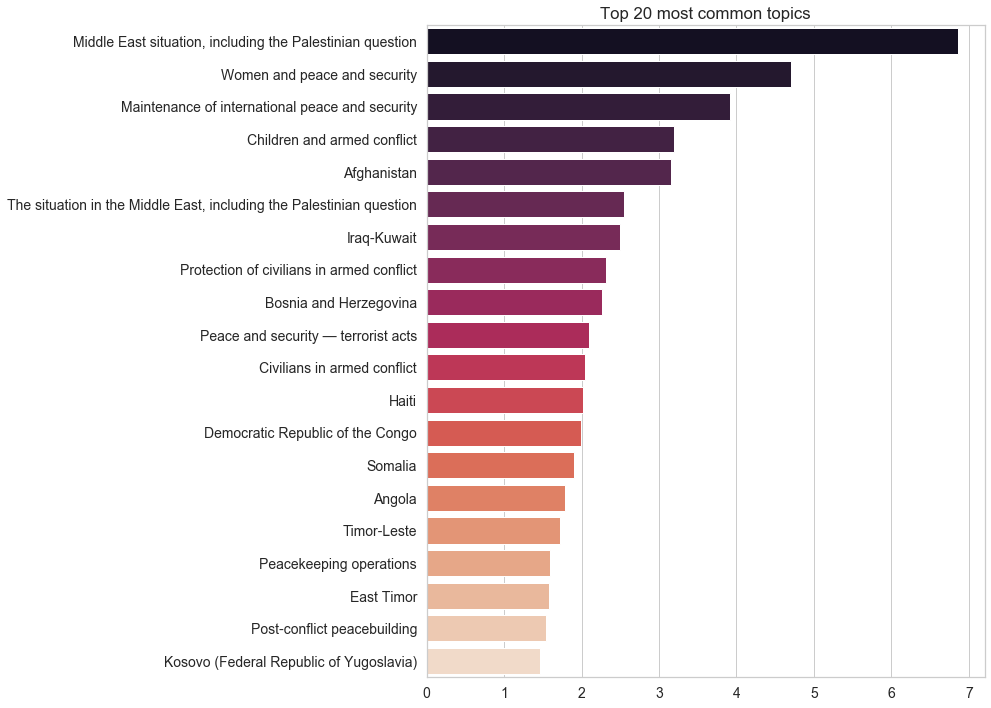

In [389]:
viz_top20_topics(overall_most_common())

### Now we look at the most common topics for each year:

In [492]:
def most_common_topics():
    """
    Gathers the most common topics of the UNSC of all countries involved per year
    
    Returns:
            topics: Dictionary containing years as keys and a topics, occurences tuple as values
    
    """
    topics = {}
    for year in range(1995,2018):
        file = str(year)+'.csv'
        year_speeches = pd.read_csv('./data/UNSC/years/'+file,delimiter=',',encoding='utf-8')
        values = year_speeches['Topic'].value_counts().keys().tolist()[:5]
        counts = year_speeches['Topic'].value_counts().tolist()[:5]
        most_common = list(zip(values, counts))
        topics[year] = most_common[:5]
    return topics

For example, these were the 5 most discussed topics in 1995:

In [491]:
most_common_topics()[1995]

[('Federal Republic of Yugoslavia (Serbia and Montenegro) — Sanctions', 168),
 ('The situation in the occupied Arab territories', 147),
 ('Bosnia and Herzegovina', 141),
 ('Angola', 108),
 ('Rwanda', 103)]

### Now we also create a visual representation of these results:

In [493]:
def most_common_viz(startyear, endyear):   
    """
    Visualizes the most common topics (in percent) in the UNSC speeches per year
    
    Input:
            startyear: first year to be visualized
            endyear: last year to be visualized
    """
    tops = most_common_topics()
    for year in range(startyear,endyear+1):
        file = str(year)+'.csv'
        year_speeches = pd.read_csv('./data/UNSC/years/'+file,delimiter=',',encoding='utf-8')
        total_speeches = len(year_speeches)
        top = [val[0] for val in tops[year]]
        occ = [val[1]/total_speeches*100 for val in tops[year]]

        sns.set(style="whitegrid")
        f, ax = plt.subplots(figsize=(6, 8))
        ax.set_xlim([0,25])

        sns.barplot(y=top, x=occ,orient='h', palette="rocket").set_title("Topics of "+ str(year)+' in percent')
        name = str(year)+'_most_common_topics'
        ###f.savefig('./img/mostcommonyear/'+name,bbox_inches='tight')


We can now look at the most common topics per year - for example 1995:

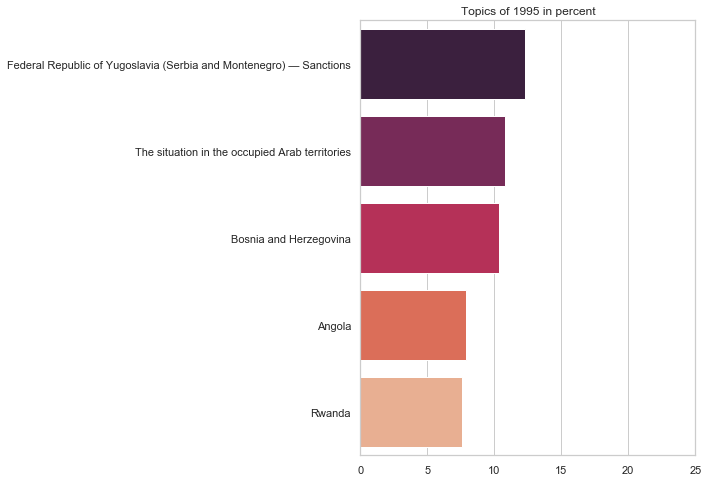

In [400]:
most_common_viz(1995,1995)

### What topics had the most negative characteristics?

In [274]:
def get_lowest():
    """
    Extracts the 5 country/year combinations for most negative sentiment, largest amount of negative sentences and
    highest subjectivity using the average data frame
    
    Returns:
            3 lists, containing the most negative country/year combinations described above
    """
    avg_df, countries = avg_data()
    neg = avg_df.nlargest(5, 'Negative_Sentences')
    vader = avg_df.nsmallest(5, 'Vader_Sentiment')
    blob_subj = avg_df.nlargest(5, 'Blob_Subjectivity')
    
    return neg[['Country', 'Year']].values.tolist(), vader[['Country', 'Year']].values.tolist(), blob_subj[['Country', 'Year']].values.tolist()

In [275]:
get_lowest()

([['Sudan', 1996],
  ['Zaire', 1996],
  ['Oman', 2010],
  ['Central African Republic', 2001],
  ['Papua New Guinea', 2007]],
 [['The Sudan', 2016],
  ['Djibouti', 2006],
  ['African Union', 2002],
  ['Azerbaijan', 2008],
  ['Libya', 2001]],
 [['0.433589212', 2003],
  ['Marshall Islands', 2003],
  ['Jamaica', 2007],
  ["Lao People's Democratic Republic", 1999],
  ['Tanzania', 2014]])

In [494]:
def examine_lowest():
    
    """
    Takes the information provided by get_lowest() and returns the topics of the respective speeches
    
    Returns:
            topics_vader: list, topics for most negative sentiment compound score/country combinations
            topics_neg: list, topics for highest amount of negative sentences/country combinations
            topics_subj: list, topics for most highest subjectivity score/country combinations
    
    """
    
    neg, vader, blobsubj = get_lowest()
    for elem in vader:
        year = elem[1]
        country = elem[0]
        speechname = str(year)+'.csv'
        speech = pd.read_csv('./data/UNSC/years/'+speechname,delimiter=',',encoding='utf-8')
        topic = speech[['Topic', 'Vader_Sentiment']]
        topics_vader = list(set(topic.nsmallest(5, 'Vader_Sentiment')['Topic']))
        
    for elem in neg:
        year = elem[1]
        country = elem[0]
        speechname = str(year)+'.csv'
        speech = pd.read_csv('./data/UNSC/years/'+speechname,delimiter=',',encoding='utf-8')
        topic = speech[['Topic', 'Negative_Sentences']]
        topics_neg = list(set(topic.nsmallest(5, 'Negative_Sentences')['Topic']))  
        
    for elem in blobsubj:
        year = elem[1]
        country = elem[0]
        speechname = str(year)+'.csv'
        speech = pd.read_csv('./data/UNSC/years/'+speechname,delimiter=',',encoding='utf-8')
        topic = speech[['Topic', 'Blob_Subjectivity']]
        topics_subj = list(set(topic.nsmallest(5, 'Blob_Subjectivity')['Topic']))
        
    print('Topics with the most negative sentiment: \n', topics_vader)
    print('\n Topics with the most negative sentences: \n', topics_neg)
    print('\n Topics with the highest subjectivity: \n', topics_subj)
    return topics_vader, topics_neg, topics_subj
    

In [279]:
examine_lowest()

Topics with the most negative sentiment: 
 ['Protection of civilians in armed conflict', 'Middle East situation, including the Palestinian question', 'Peace and security — terrorist acts']

 Topics with the most negative sentences: 
 ['Democratic Republic of the Congo', 'Peace and security']

 Topics with the highest subjectivity: 
 ['Mali', 'Democratic Republic of the Congo', 'Central African Republic']


(['Protection of civilians in armed conflict',
  'Middle East situation, including the Palestinian question',
  'Peace and security — terrorist acts'],
 ['Democratic Republic of the Congo', 'Peace and security'],
 ['Mali', 'Democratic Republic of the Congo', 'Central African Republic'])

---

# 4. And what did the core nations discuss?

#### The five permanent (or core) members of the United Nations Security Council are China, France, Russian Federation, the United Kingdom, and the United States. These nations have the power of veto and can thus prevent Council resolutions from being adopted


In [495]:
def topics_core():
    """
    Extracts the topics that lead to the most subjective and the most negative speech
    for each core country
    
    Returns: 
            outliers: Data frame containing information about the outliers with respective topics, years and countries
    
    """
    
    ### get most negative and subjective topics per country
    avg_df = get_core_nations()
    criteria = ["Vader_Sentiment", 'Blob_Subjectivity']
    tops = []
    countries = corelist()
    for country in countries:
        for crit in criteria:
            temp = avg_df.loc[avg_df['Country'] == country]
            if (crit == 'Blob_Subjectivity'):
                row = temp[temp[crit] == temp[crit].max()]
                year = row['Year'].item()
                speechname = str(year)+'.csv'
                speech = pd.read_csv('./data/UNSC/years/'+speechname,delimiter=',',encoding='utf-8')
                speech = speech.loc[speech['Country'] == country]
                topic = speech[['Topic', crit]]
                tops.append((country, year, crit, topic.nlargest(1, crit)['Topic'].item(),topic.nlargest(1, crit)[crit].item()))
            else: 
                
                row = temp[temp[crit] == temp[crit].min()]
                year = row['Year'].item()
                speechname = str(year)+'.csv'
                speech = pd.read_csv('./data/UNSC/years/'+speechname,delimiter=',',encoding='utf-8')
                speech = speech.loc[speech['Country'] == country]
                topic = speech[['Topic', crit]]
                
                
                tops.append((country, year, crit, topic.nsmallest(1, crit)['Topic'].item(),topic.nsmallest(1, crit)[crit].item()))
                 
                
    outliers = pd.DataFrame(tops, columns=['Country', 'Year', 'Criterion', 'Topic', 'Score'])
    
    return outliers

In [403]:
topics_core().head()

,Country,Year,Criterion,Topic,Score
0,France,2015,Vader_Sentiment,Women and peace and security,-0.997500
1,France,2002,Blob_Subjectivity,East Timor,0.541255
2,Russian Federation,2016,Vader_Sentiment,Threats to international peace and security ca...,-0.998300
3,Russian Federation,1996,Blob_Subjectivity,Iraq-Kuwait,0.513091
4,China,2015,Vader_Sentiment,Threats to international peace and security ca...,-0.998800


In [460]:
def outlier_core_viz():
    outliers = topics_core()
    subj_df = outliers.loc[outliers['Criterion'] == 'Blob_Subjectivity']
    sent_df = outliers.loc[outliers['Criterion'] == 'Vader_Sentiment']
    plt.xticks(rotation=90)
    sns.barplot(x="Country", y="Score", hue="Topic", data=subj_df).set_title("Highest subjectivity score")
    ###plt.savefig('./img/core_img/highestsubjectivitycore.png', bbox_inches='tight')
    plt.show()
    
    
    ax = sns.barplot(x="Country", y="Score", hue="Topic", data=sent_df)
    plt.xticks(rotation=90)
    ax.invert_yaxis()
    ax.set_title("Lowest sentiment score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ###plt.savefig('./img/core_img/lowestsentimentcore.png', bbox_inches='tight')
    plt.show()



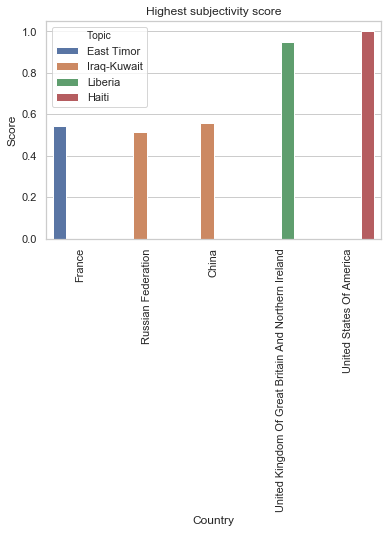

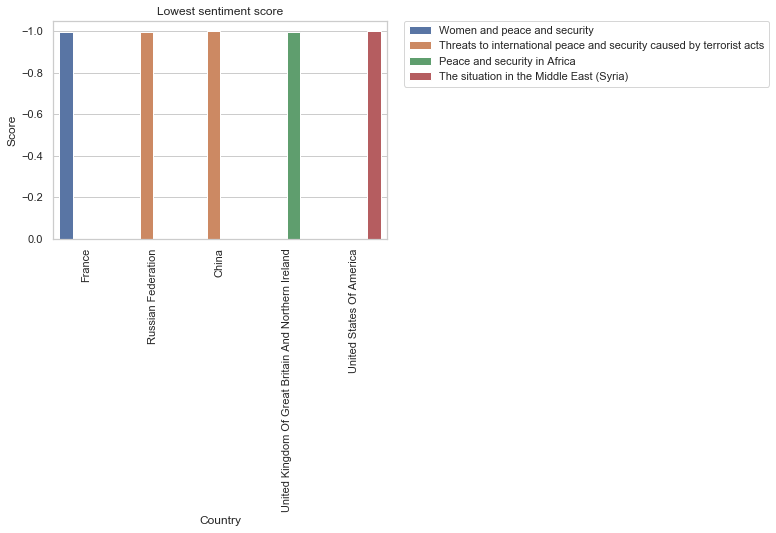

In [412]:
outlier_core_viz()

___

## We can also briefly visualize how consistent in respect to the criteria the countries were 
We will do this by looking at the standard deviation of each feature for every country over time

In [496]:
def core_std():
    """
    Calculates the standard deviation over the years for each country country 
    
    Returns:
            std_df: Data frame containing the standard deviation for each country/year
    """
    corecount = corelist()
    std_values = []
    for year in range(1995, 2018):
        yeardf = pd.read_csv('./data/UNSC/years/'+str(year)+'.csv',delimiter=',',encoding='utf-8')
        for country in corecount:
            countrydf = yeardf.loc[yeardf['Country'] == country]
            
            subjectivity = countrydf['Blob_Subjectivity'].std()
            sentiment = countrydf['Vader_Sentiment'].std()
            pos_sents = countrydf['Positive_Sentences'].std()
            neg_sents = countrydf['Negative_Sentences'].std()
            
            std_values.append((country, year, subjectivity, sentiment, pos_sents, neg_sents ))
    std_df = pd.DataFrame(std_values, columns = ['Country', 'Year', 'Subj_std', 'Vader_std', 'Pos_Sentences_std', 'Neg_Sentences_std']) 
    std_df.dropna()
    ###std_df.to_csv ('./data/UNSC/core_std_scores.csv', index = None, header=True)
    return std_df



In [420]:
core_std().head()

,Country,Year,Subj_std,Vader_std,Pos_Sentences_std,Neg_Sentences_std
0,France,1995,0.108173,0.365988,9.832636,3.471854
1,Russian Federation,1995,0.139770,0.324282,8.528620,3.474631
2,China,1995,0.090010,0.114585,8.276333,2.628665
3,United Kingdom Of Great Britain And Northern I...,1995,0.077438,0.423619,10.396961,4.024285
4,United States Of America,1995,0.056969,0.468862,12.802098,4.926366


In [473]:
def std_viz(feature):
    """
    Visualizes subjectivity development of all countries over time,
    fill in the years
    """
    overview = pd.read_csv('./data/UNSC/core_std_scores.csv',delimiter=',',encoding='utf-8')
    corecountries = corelist()

    subplot = sns.lineplot(x="Year", y=feature, hue='Country', data=overview)
    axes = plt.gca()
    axes.set_xlim([1995,2017])
    #axes.set_ylim([-0.1,1.1])
    axes.xaxis.set_major_locator(MaxNLocator(nbins = 40,integer=True))
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig = subplot.get_figure()
    plt.show()
    ###fig.savefig('./img/core_img/core_std_'+feature, bbox_inches='tight')

In [425]:
def std_viz_call():
    """
    Calls the standard deviation visualization function std_viz() for each year
    """
    for feature in ['Subj_std', 'Vader_std', 'Pos_Sentences_std', 'Neg_Sentences_std']:
        std_viz(feature)

When we look at the standard deviation, it looks quite messy but some trends are visible. E.g. quite a big standard deviation in the United states for the amount of negative sentences in 2003. This is not visible in the Vader sentiment standard deviation but still worth exploring.

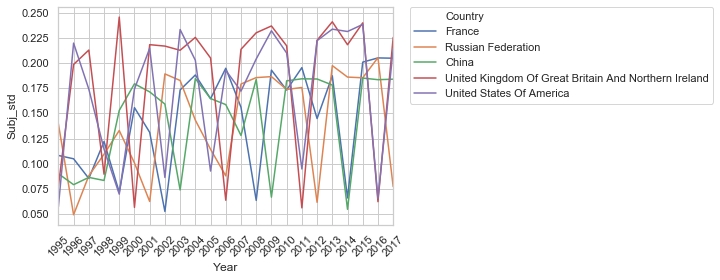

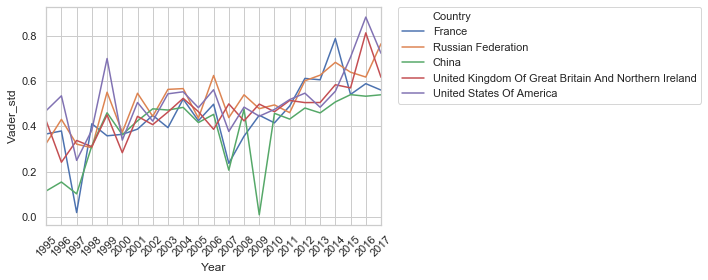

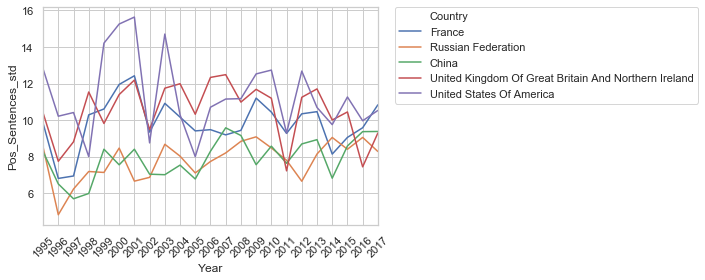

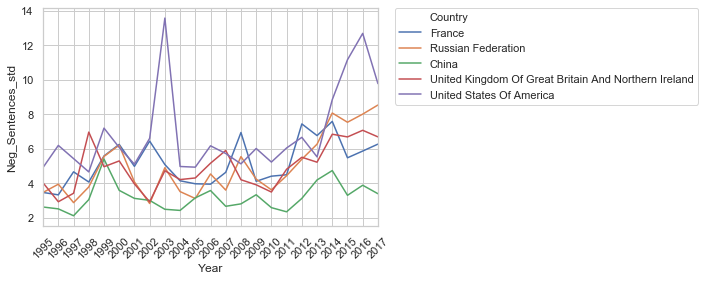

In [426]:
std_viz_call()

### Visualization of the sentiment and subjectivity development for UNSC core nations over time

In [462]:
def core_viz_helper(df, feature):
    """
    A template visualization function that can be called for each
    feature to plot the core nation's sentiment/subjectivity development 
    over time
    
    Input:
            df: data frame containing country/year/feature information
            feature: string indicating which feature is plotted
    """
    
    plot = sns.lineplot(x="Year", y=feature, hue='Country', data=df)
    axes = plt.gca()
    axes.set_xlim([1995,2017])
    if feature in ["Vader_Sentiment","Blob_Subjectivity"]:
        axes.set_ylim([-0.1,1.1])
    else: axes.set_ylim([0,23])
    axes.xaxis.set_major_locator(MaxNLocator(nbins = 20,integer=True))
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig = plot.get_figure()
    ###fig.savefig('./img/core_img/over_time_'+feature, bbox_inches='tight')
    plt.show()

In [430]:
def core_viz(avg_df):
    """
    Provides a visualization of the core nation's sentiment/subjectivity development 
    over time
    
    Input:
            avg_df: data frame containing the average data for the core countries
    
    """
 
    vad = avg_df[['Year', 'Country', "Vader_Sentiment"]]
    sub = avg_df[['Year', 'Country', "Blob_Subjectivity"]]
    pos = avg_df[['Year', 'Country', "Positive_Sentences"]]
    neg = avg_df[['Year', 'Country', "Negative_Sentences"]]
    
    core_viz_helper(vad, 'Vader_Sentiment')
    core_viz_helper(sub, 'Blob_Subjectivity')
    core_viz_helper(pos, 'Positive_Sentences')
    core_viz_helper(neg, 'Negative_Sentences')
    

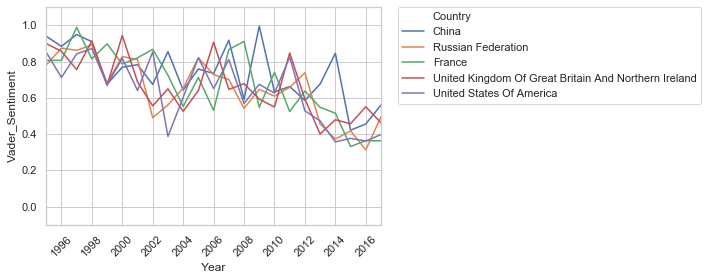

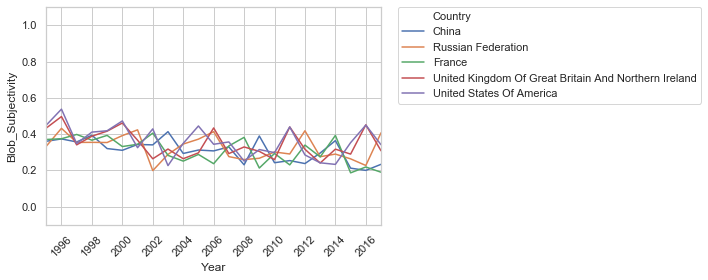

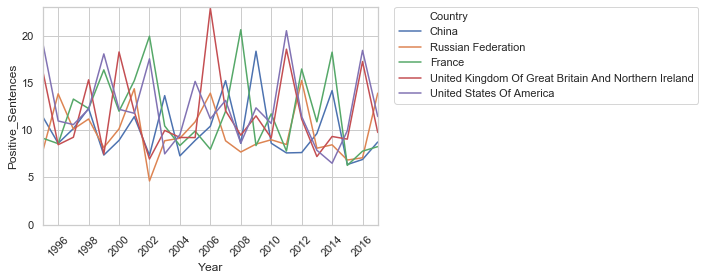

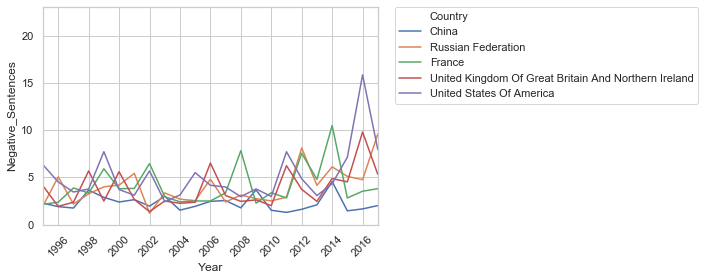

In [431]:
core_viz(get_core_nations())

---

# 5. Closer look at the sentiment and subjectivity in Iraq War related UNSC speeches

In [497]:
def opinion_iraq():
    """
    Extracts core nations opinion on the middle east over time
    
    Returns:
            df: Data frame containing compound sentiment scores for each year/country
    """
    corecount= corelist()
    topic = ["Iraq-Kuwait", "Iraq"]
    overview = []
    for country in corecount:
        for year in range(1995,2018):
            file = str(year)+'.csv'
            year_speeches = pd.read_csv('./data/UNSC/years/'+file,delimiter=',',encoding='utf-8')
            countrydf = year_speeches.loc[year_speeches['Country'] == country]
          
            avg_vader = countrydf.loc[countrydf['Topic'].isin(topic)]['Vader_Sentiment'].mean()
            overview.append((year, country, avg_vader))
            
            df = pd.DataFrame(overview, columns=['year', 'country', 'vader'])
            ###df.to_csv('./data/UNSC/vaderiraq.csv', sep=',', encoding='utf-8', index=False)
    return df

In [436]:
opinion_iraq().head()

,year,country,vader
0,1995,France,0.995200
1,1996,France,0.958700
2,1997,France,0.992175
3,1998,France,0.983850
4,1999,France,0.769120


In [498]:
def sentence_wise_iraq():
    """
    Computes the number of positive/negative sentences in Iraq war related speeches for every country
    
    We just look at the years 1999-2006 because we are specifically looking for Iraq war (2003) related scores
    
    Returns:
            sentoverview: Overview of amount of pos/neg sentences described above
    
    """
    year_sum = {}
    sentoverview = []
    topic = ["Iraq-Kuwait", "Iraq"]
    corecount = corelist()
    
    for year in range(1999, 2007):
        file = str(year)+'.csv'
        year_speeches = pd.read_csv('./data/UNSC/years/'+file,delimiter=',',encoding='utf-8')
        year_speeches = year_speeches.loc[year_speeches['Country'].isin(corecount)]
        year_speeches = year_speeches.loc[year_speeches['Topic'].isin(topic)]

        for count in corecount:
            country = year_speeches.loc[year_speeches['Country']==count]
            subjectivity = country['Blob_Subjectivity'].mean()
            sentoverview.append((year, count, country['Positive_Sentences'].sum(), country['Negative_Sentences'].abs().sum(), subjectivity ))
    
    df = pd.DataFrame(sentoverview, columns=['Year', 'Country', 'Positive_Sentences', 'Negative_Sentences', 'Subjectivity'])
    ###df.to_csv('./data/UNSC/iraqscores.csv', sep=',', encoding='utf-8', index=False)
    return sentoverview

In [438]:
sentence_wise_iraq()[:5]

[(1999, 'France', 63, 13, 0.5043955376),
 (1999, 'Russian Federation', 67, 32, 0.43505585133333335),
 (1999, 'China', 56, 26, 0.4870871625),
 (1999,
  'United Kingdom Of Great Britain And Northern Ireland',
  93,
  7,
  0.5977922136666667),
 (1999, 'United States Of America', 105, 16, 0.43259102)]

In [477]:
def iraq_sent_viz():
    """
    Creates a stacked barplot for the negative/positive sentences in Iraq war related speeches for each country
    """
    
    overview = pd.read_csv('./data/UNSC/iraqscores.csv',delimiter=',',encoding='utf-8')
    corecountries = corelist()
    for country in corecountries:
        df = overview.loc[overview['Country']==country]
        subplot = df.plot(kind='bar',x='Year', y=['Positive_Sentences', 'Negative_Sentences'], stacked=True, title=country)
        plt.xticks(rotation=45)
        fig =subplot.get_figure()
        ###fig.savefig('./img/iraq/iraq_scores_'+country)
        

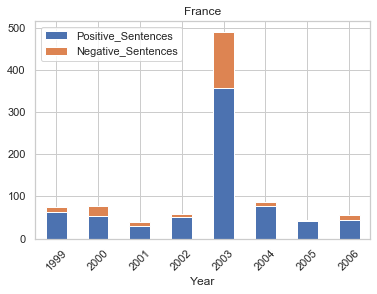

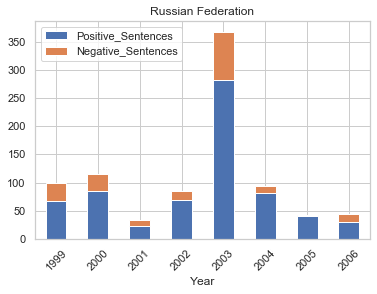

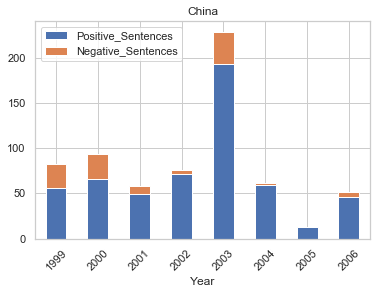

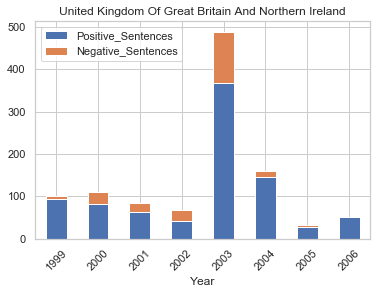

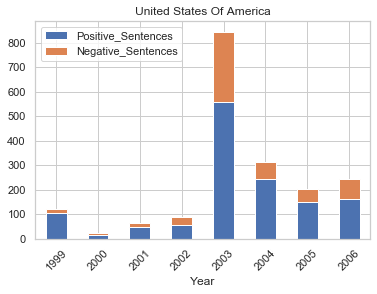

In [440]:
iraq_sent_viz()

## What about the subjectivity of the core nations with respect to Iraq war related speeches?


In [478]:
def iraq_subj_viz():
    """
    Visualizes subjectivity development of all countries over time,
    fill in the years
    """
    overview = pd.read_csv('./data/UNSC/iraqscores.csv',delimiter=',',encoding='utf-8')
    corecountries = corelist()

    subplot = sns.lineplot(x="Year", y="Subjectivity", hue='Country', data=overview)
    axes = plt.gca()
    axes.set_xlim([1999,2006])
    axes.set_ylim([-0.1,1.1])
    axes.xaxis.set_major_locator(MaxNLocator(nbins = 20,integer=True))
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig = subplot.get_figure()
    ###fig.savefig('./img/iraq/iraq_subj_all', bbox_inches='tight')

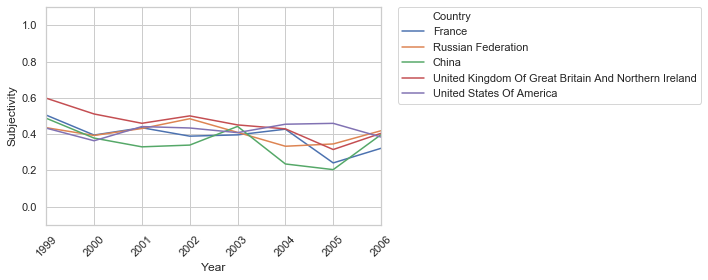

In [445]:
iraq_subj_viz()

In [479]:
def iraq_subj_viz_single():
    """
    Visualizes subjectivity development for each country over time,
    ##fill in the years
    """
    overview = pd.read_csv('./data/UNSC/iraqscores.csv',delimiter=',',encoding='utf-8')
    corecountries = corelist()
    for country in corecountries:
        df = overview.loc[overview['Country']==country]
        subplot = sns.lineplot(x="Year", y="Subjectivity",  data=df, palette='rocket').set_title("Subjectivity score Iraq - "+country)
        axes = plt.gca()
        axes.set_xlim([1999,2006])
        axes.set_ylim([-0.1,1.1])
        axes.xaxis.set_major_locator(MaxNLocator(nbins = 20,integer=True))
        plt.xticks(rotation=45)
        plt.show()
        fig = subplot.get_figure()
        ###fig.savefig('./img/iraq/iraq_subj_'+country, bbox_inches='tight')

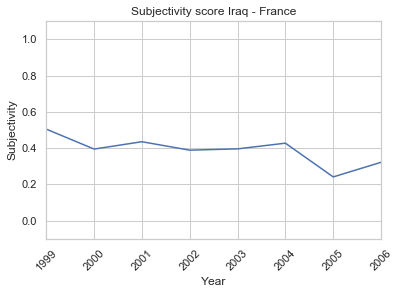

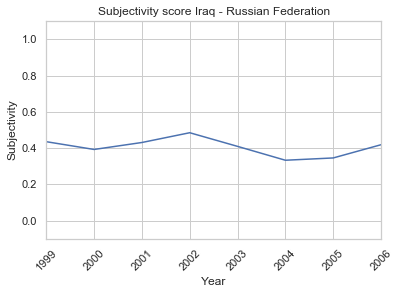

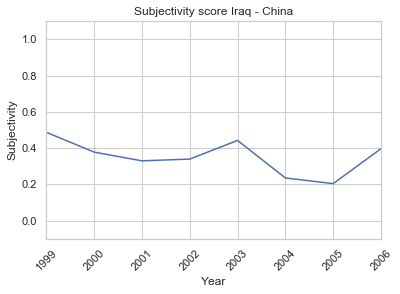

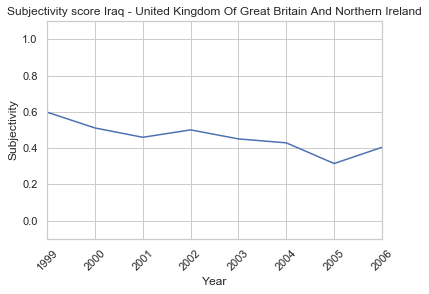

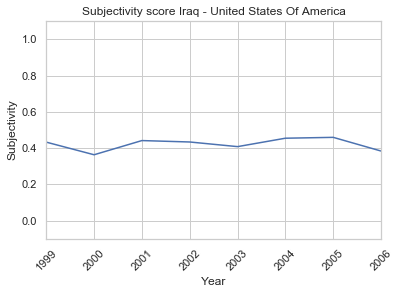

In [449]:
iraq_subj_viz_single()

___

# 6. Closer look at two specific sessions related to the Iraq war

### First, let's prepare the visualization

In [467]:
def resolutionviz(resolution, name):
    """
    
    Input:
            resolution: Data frame containing all information related to the respective resolution
            name: string, name of the resolution to be analyzed
    
    Returns: Data frame containing 
            
    """
    countries = get_countries(resolution)
    overview = []
    for country in countries:
        df = resolution.loc[resolution['Country']==country]
        overview.append((country, df['Positive_Sentences'].sum(), df['Negative_Sentences'].sum(), df['Blob_Subjectivity'].mean()))
    plotdf = pd.DataFrame(overview, columns=['Country', 'Positive_Sentences', 'Negative_Sentences', 'Subjectivity'])

        
    subplot = plotdf.plot(kind='bar',x='Country', y=['Positive_Sentences', 'Negative_Sentences'], stacked=True, title=name+' Sentiment Analysis')
    plt.xticks(rotation=90)
    fig = subplot.get_figure()
    ###fig.savefig('./img/iraq/'+name+'_sentiment', bbox_inches='tight')
    plt.show()
    
    subplot1 = plotdf.plot(x='Country', y='Subjectivity', title = name+' Subjectivity Analysis')
    axes = plt.gca()
    axes.set_ylim([-0.1,1.1])
    plt.xticks(plotdf.index, plotdf['Country'], rotation=90)
    fig = subplot1.get_figure()
    ###fig.savefig('./img/iraq/'+name+'_subjectivity', bbox_inches='tight')
    plt.show()
    
    return plotdf

## Now the two sessions:

## Resolution 1441
>  On November 8, the council adopted Resolution 1441, which required the Iraqi government to complete a series of disarmament requirements contained in previous council resolutions, the first of which was adopted in 1991 following the Persian Gulf War. <br>
These events took place against a backdrop of indications from U.S. officials, including President George W. Bush, that Washington might use military force against Iraq to end what they portrayed as the threat posed by Baghdad’s nonconventional weapons. <br>
*(https://www.armscontrol.org/act/2013-01/looking-back-iraq-disarmament-without-resolution)*

In [499]:
def res1441():
    """
    Reads in the speech data for resolution 1441 and calls the resolution visualization function
    """
    session = pd.read_csv('./data/UNSC/years/2002.csv',delimiter=',',encoding='utf-8')
    ses1441 = session.loc[session['Speech_ID'].str.startswith('UNSC_2002_SPV.4644')]
    resolutionviz(ses1441, 'Resolution 1441')

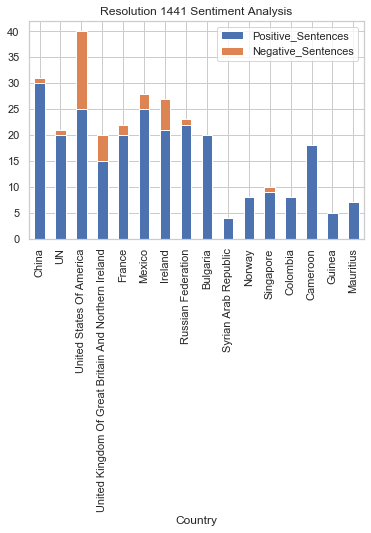

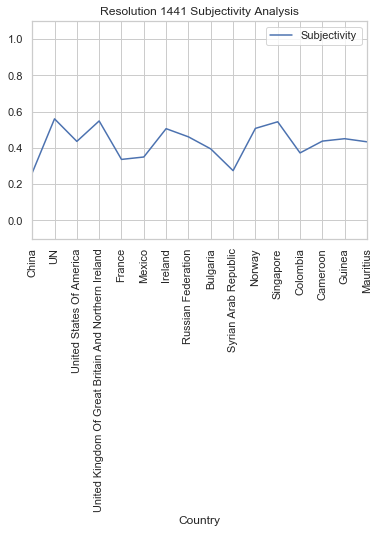

In [453]:
res1441()

## Powell Speech (USA)

> U.S. Secretary of State Colin Powell gives a speech to the United Nations that is both highly consequential and full of fabrications on February 5, 2003. Using talking points that many within his own government had told him were either misleading or outright lies, Powell outlined the United States' case that Iraq possessed weapons of mass destruction, making the argument for the invasion that would happen the following month. <br>
*(https://www.history.com/this-day-in-history/secretary-of-state-colin-powell-speaks-at-un-invasion-of-iraq)*

Powell himself stated later:
> "I, of course, regret the U.N. speech that I gave which became the prominent presentation of our case. But we thought it was correct at the time. The President thought it was correct. Congress thought it was correct." <br>
*(The Daily Show, 13 Jun 2012)*

___

In [500]:
def powell():
    """
    Reads in the speech data for resolution 1441 and calls the resolution visualization function
    """
    session = pd.read_csv('./data/UNSC/years/2003.csv',delimiter=',',encoding='utf-8')
    powell = session.loc[session['Speech_ID'].str.startswith('UNSC_2003_SPV.4701')]
    resolutionviz(powell, 'Powell Speech')

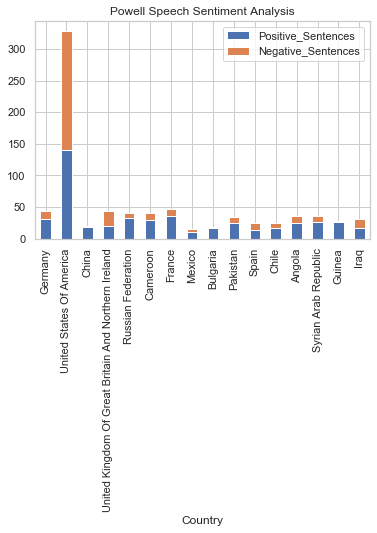

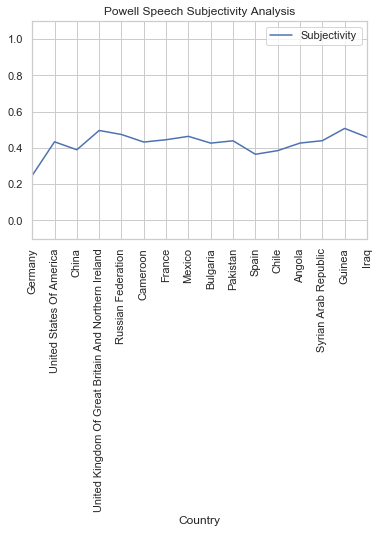

In [455]:
powell()